In [3]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy.stats import nbinom, gamma, fisher_exact
from scipy.special import digamma
from scipy.optimize import minimize
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


<h1> Helper Functions </h1>  

In [4]:
def download_faer_files(root_dir):
    # Defines root directory where FAERS datasets are located
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    # Adjusts range of files to download (can be 2024 to 2025) 
    all_quarters = [f"{str(y)[2:]}{q}" for y in range(2024, 2026) for q in quarters]

    # Limits to only those quarters that exist (sanity check)
    existing_quarters = [q for q in all_quarters if os.path.exists(os.path.join(root_dir, f"DEMO{q}.txt"))]

    # Stores DataFrames in a dict
    data = {}

    for q in existing_quarters:
        try:
            data[q] = {
                'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'reac': pd.read_csv(os.path.join(root_dir, f"REAC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'outc': pd.read_csv(os.path.join(root_dir, f"OUTC{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'indi': pd.read_csv(os.path.join(root_dir, f"INDI{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'rpsr': pd.read_csv(os.path.join(root_dir, f"RPSR{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
                'ther': pd.read_csv(os.path.join(root_dir, f"THER{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
            }
            print(f"Loaded {q} successfully.")
        except Exception as e:
            print(f"Error loading data for {q}: {e}")
    return data



In [5]:
def generate_periods(start_year, start_quarter, end_year, end_quarter):
    periods = []
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']

    start_year = int(start_year)
    end_year = int(end_year)

    # Loops through the years and quarters to generate all periods in the range
    for year in range(start_year, end_year + 1):
        start_qtr = start_quarter if year == start_year else 'Q1'
        end_qtr = end_quarter if year == end_year else 'Q4'

        for qtr in quarters[quarters.index(start_qtr):quarters.index(end_qtr) + 1]:
            periods.append(f"{str(year)[-2:]}{qtr}")
    return periods


In [6]:
def create_dataframes(start_year, start_quarter, end_year, end_quarter):
    # Generates periods based on user input
    periods = generate_periods(start_year, start_quarter, end_year, end_quarter)
    print(periods)

    # Lists of table types to be processed 
    table_types = ['demo', 'drug', 'reac', 'outc', 'indi', 'rpsr', 'ther']

    # Initializes a dictionary to store lists of DataFrames for each table
    data_dict = {table: [] for table in table_types}

    # Loops through each period and collect data for each table type
    for period in periods:
        if period in data:  # Check if data for the period exists
            for table in table_types:
                if table in data[period]:
                    data_dict[table].append(data[period][table])
        else:
            print(f"Warning: No data available for {period}")

    # Concatenates data for each table type into a single DataFrame
    merged_data = {
        table: pd.concat(data_dict[table], ignore_index=True) if data_dict[table] else pd.DataFrame()
        for table in table_types
    }

    demo = merged_data['demo']
    drug = merged_data['drug']
    reac = merged_data['reac']
    outc = merged_data['outc']
    indi = merged_data['indi']
    rpsr = merged_data['rpsr']
    ther = merged_data['ther']

    return demo, drug, reac, outc, indi, rpsr, ther


In [7]:
def preprocess_drug_df(drug, name_mapping):
    drug = drug[['primaryid', 'caseid', 'role_cod', 'drugname', 'prod_ai', 'drug_seq', 'dechal', 'rechal']]
    
    print("Starting number of reports in 'drug' file: ", drug.shape[0]) 
    
    drug = drug[drug['role_cod'] == 'PS']
    print("Number of reports in the 'drug' file where drug is the primary suspect: ", drug.shape[0]) 

    drug = drug[pd.notnull(drug['drugname'])]  # Drops Nulls
    drug = drug[~drug['drugname'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'drug' file after unknown/null drugs are removed: ", drug.shape[0]) 
    
    drug['drugname'] = drug['drugname'].str.strip().str.lower()  # Stips whitespace, Transforms to lowercase

    # Add in rxnorm mapping results
    drug = drug.merge(
        name_mapping[['drugname', 'best_match_name', 'rxnorm_name']],
        how='left',
        on='drugname'
    )
    
    drug['drugname'] = drug['drugname'].str.replace('\\', '/')  # Standardizes slashes to '/'
    drug['drugname'] = drug['drugname'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    drug['prod_ai'] = drug['prod_ai'].str.lower()
    drug = drug.drop_duplicates(subset=['primaryid'], keep='first')

    
    return drug


In [8]:
def preprocess_reac_df(reac):
    print("Starting number of reports in 'reac' file: ", reac.shape[0]) 

    reac = reac[pd.notnull(reac['pt'])] # Drops Nulls
    reac = reac[~reac['pt'].isin(['unknown'])]  # Drops unknowns
    
    print("Number of reports in the 'reac' file after unknown/null reacs are removed: ", reac.shape[0]) 

    reac['pt'] = reac['pt'].str.strip().str.lower()  # Transforms to lowercase
    reac['pt'] = reac['pt'].map(
        lambda x: x[:-1] if str(x).endswith(".") else x)  # Removes periods at the end of drug names

    return reac


In [9]:
def preprocess_demo_df(demo):
    print("Starting number of reports in 'demo' file: ", demo.shape[0]) 

    demo = demo[['primaryid', 'caseid', 'caseversion', 'age_cod', 'age', 'sex', 'wt', 'fda_dt', 'event_dt', 'occr_country']]
    
    # If multiple reports have the same primary id and case id, keep the most recent one 
    demo = demo.sort_values(by=['caseid', 'fda_dt', 'primaryid'], ascending=[True, False, False])
    demo = demo.drop_duplicates(subset=['caseid'], keep='first')
    
    print("Number of reports in the 'demo' file after duplicate primary/case id combos are removed: ", demo.shape[0]) 

    demo = demo[pd.notnull(demo['age'])]
    demo = demo[demo.age_cod != 'dec'].reset_index(drop=True)
    demo['age'] = demo['age'].apply(pd.to_numeric, errors='coerce')
    demo['age'] = np.where(demo['age_cod'] == 'MON', demo['age'] * 1 / 12, demo['age'])  # mounth
    demo['age'] = np.where(demo['age_cod'] == 'WK', demo['age'] * 1 / 52, demo['age'])  # week
    demo['age'] = np.where(demo['age_cod'] == 'DY', demo['age'] * 1 / 365, demo['age'])  # day
    demo['age'] = np.where(demo['age_cod'] == 'HR', demo['age'] * 1 / 8760, demo['age'])  # hour
    demo = demo.drop(['age_cod'], axis=1)

    print("Number of reports in the 'demo' file after unknown/invalid ages are removed: ", demo.shape[0]) 


    return demo


In [10]:
def preprocess_outc_df(outc): 
    print("Starting number of reports in 'outc' file: ", reac.shape[0]) 

    outc['outc_number'] = outc.groupby(['primaryid', 'caseid']).cumcount() + 1
    
    outc_pivot = outc.pivot(index=['primaryid', 'caseid'], 
                        columns='outc_number', 
                        values='outc_cod')
    
    # Renames the columns to outc_cod1, outc_cod2, ...
    outc_pivot.columns = [f'outc_cod{i}' for i in outc_pivot.columns]
    outc_final = outc_pivot.reset_index()
    
    return outc_final

In [11]:
def preprocess_ther_df(ther):
    print("Starting number of reports in 'ther' file: ", ther.shape[0]) 

    ther = ther[['primaryid', 'caseid', 'start_dt', 'dsg_drug_seq']] 

    ther = ther.rename(columns={'dsg_drug_seq': 'drug_seq'})

    return ther


In [12]:
def load_filtered_mapping(mapping_path, drug_df):
    
    # Load full mapping
    print(f"Loading RxNorm mapping from: {mapping_path}")
    mapping = pd.read_csv(mapping_path)

    # Get unique drugnames from FAERS drug table for given time frame
    faers_drugnames = drug_df['drugname'].dropna().unique()

    # Only keep relevant names to minimize merge time
    mapping = mapping[mapping['drugname'].isin(faers_drugnames)]

    return mapping

In [13]:
def preprocess_indi_df(indi):
    print("Starting number of reports in 'indi' file: ", indi.shape[0]) 

    indi = indi.rename(columns={'indi_drug_seq': 'drug_seq'})

    return indi


In [14]:
def phv_ebgm_qn(theta_hat, N, E):
    r1, b1, r2, b2, p = theta_hat
    prob_f1 = b1 / (b1 + E)
    prob_f2 = b2 / (b2 + E)
    f1_nb = nbinom.pmf(N, n=r1, p=prob_f1)
    f2_nb = nbinom.pmf(N, n=r2, p=prob_f2)
    num = p * f1_nb
    den = num + (1 - p) * f2_nb
    return num / den

def phv_ebgm_score(theta_hat, N, E, qn):
    r1, b1, r2, b2, _ = theta_hat
    e1 = digamma(r1 + N) - np.log(b1 + E)
    e2 = digamma(r2 + N) - np.log(b2 + E)
    exp_log = qn * e1 + (1 - qn) * e2
    eb_log2 = exp_log / np.log(2)
    return 2 ** eb_log2

def phv_ebgm_quant_bisect(cut_point, theta_hat, N, E, qn,
                          digits=2, limits=(-1e5, 1e5), max_iter=2000):
    r1, b1, r2, b2, _ = theta_hat
    lower, upper = limits
    tol = 0.5 * 10 ** (-digits)

    def post_cdf_minus_cp(x):
        c1 = gamma.cdf(x, a=r1 + N, scale=1/(b1 + E))
        c2 = gamma.cdf(x, a=r2 + N, scale=1/(b2 + E))
        return qn * c1 + (1 - qn) * c2 - cut_point

    N = np.asarray(N)
    E = np.asarray(E)
    qn = np.asarray(qn)

    guess = np.ones_like(N, dtype=float)
    err0 = post_cdf_minus_cp(guess)
    is_pos = err0 > 0
    left = np.where(is_pos, lower, guess)
    right = np.where(is_pos, guess, upper)

    for _ in range(max_iter):
        mid = (left + right) / 2
        err_mid = post_cdf_minus_cp(mid)
        if np.max((right - left) / 2) < tol:
            q = np.round(mid, digits)
            if np.any(q == upper):
                raise ValueError("increase maximum for 'limits'")
            return q
        err_left = post_cdf_minus_cp(left)
        same = np.sign(err_left) == np.sign(err_mid)
        left = np.where(same, mid, left)
        right = np.where(same, right, mid)

    raise RuntimeError("failed to converge -- try adjusting 'limits' or 'max_iter'")

def dbinbinom(x, size1, prob1, size2, prob2, w):
    return w * nbinom.pmf(x, n=size1, p=prob1) + (1 - w) * nbinom.pmf(x, n=size2, p=prob2)

def phvid_objective(theta, N, E):
    r1, b1, r2, b2, w = theta
    prob1 = b1 / (b1 + E)
    prob2 = b2 / (b2 + E)
    pmf = dbinbinom(N, r1, prob1, r2, prob2, w)
    return np.sum(-np.log(pmf + 1e-16))  # add tiny epsilon to avoid log(0)

def phv_ebgm(a, b, c, d, alpha=0.05, theta_init=None, squashing=True):
    """
    a, b, c, d: counts (scalars or array‐like)
    alpha: two‐sided significance level
    theta_init: array‐like [r1, b1, r2, b2, p] or pandas.DataFrame of guesses
    squashing: (not implemented – placeholder)
    """
    # turn inputs into arrays
    a, b, c, d = np.broadcast_arrays(a, b, c, d)
    if np.any(a < 0) or np.any(b < 0) or np.any(c < 0) or np.any(d < 0):
        raise ValueError("a, b, c, d must be non‐negative")
    # total counts
    tot = a + b + c + d
    N = a.astype(float)
    E = (a + b) / tot * (a + c)

    # squashing placeholder
    if squashing and np.any(a == 0):
        warnings.warn("squashing=True but no squash implemented; continuing with raw counts")

    # prepare initial guess
    if theta_init is None:
        x0 = np.array([0.2, 0.1, 2.0, 4.0, 1/3])
    else:
        if isinstance(theta_init, pd.DataFrame):
            x0 = theta_init.iloc[0].values
        else:
            x0 = np.asarray(theta_init, dtype=float)
        if x0.shape[0] != 5:
            raise ValueError("theta_init must have length 5")

    # bounds: r1,b1,r2,b2 > 0; p in (0,1)
    bounds = [(1e-6, None)]*4 + [(1e-6, 1-1e-6)]
    res = minimize(phvid_objective, x0, args=(N, E),
                   bounds=bounds, method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("hyperparameter estimation failed: " + res.message)
    theta_hat = res.x

    # compute posterior weights, EBGM and CIs
    qn = phv_ebgm_qn(theta_hat, N, E)
    ebgm = phv_ebgm_score(theta_hat, N, E, qn)
    half = alpha / 2
    ci_low  = phv_ebgm_quant_bisect(half,      theta_hat, N, E, qn)
    ci_high = phv_ebgm_quant_bisect(1 - half,  theta_hat, N, E, qn)

    return pd.DataFrame({
        'ebgm':   ebgm,
        'ci_low': ci_low,
        'ci_high':ci_high
    })

In [15]:
def compute_or_and_ci(a, b, c, d):
    """
    Computes Odds Ratio (OR) and Confidence Interval (CI)
    """
    # Odds Ratio
    or_val = (a * d) / (b * c)

    # Log(OR) and standard error
    log_or = np.log(or_val)
    se = np.sqrt(1 / a + 1 / b + 1 / c + 1 / d)

    # Confidence Interval
    ci_low = np.exp(log_or - 1.96 * se)
    ci_high = np.exp(log_or + 1.96 * se)

    return or_val, ci_low, ci_high


def compute_prr_and_ci(a, b, c, d):
    """ 
    Computes Proportional Reporting Ratio (PRR), Standard Error (SE), and Confidence Interval (CI)
    """ 
    # Proportional Reporting Ratio (PRR)
    prr = (a / (a + b)) / (c / (c + d))
    
    # Log of PRR
    ln_prr = np.log(prr)

    # Standard Error (SE) of ln(PRR)
    se = np.sqrt(1/a - 1/(a + b) + 1/c - 1/(c + d))
    
    # Confidence Interval for PRR
    ci_low = np.exp(ln_prr - 1.96 * se)
    ci_high = np.exp(ln_prr + 1.96 * se)

    return prr, ci_low, ci_high

def compute_ic_and_ic025(a, b, c, d,
                        gamma_11=0.5, alpha1=0.5, beta1=0.5, 
                        alpha=2.0, beta=2.0):
    """
    Compute Bayesian Information Component (IC) and lower bound IC025
    
    Parameters:
        a, b, c, d: int or float (counts in 2x2 contingency table)
        gamma_11, alpha1, beta1, alpha, beta: prior hyperparameters
    
    Returns:
        E_IC: Expected IC value (mean)
        IC025: Lower bound of 95% credibility interval (IC - 2*std)
    """
    a, b, c, d = map(np.asarray, (a, b, c, d))
    
    N = a + b + c + d
    gamma = gamma_11 * (N + alpha) * (N + beta) / ((a + b + alpha1) * (a + c + beta1))
    
    E_IC = np.log2(((a + gamma_11) * (N + alpha) * (N + beta)) /
                   ((N + gamma) * (a + b + alpha1) * (a + c + beta1)))
    
    ln2_sq = (np.log(2))**2
    term1 = (N - a + gamma - gamma_11) / ((a + gamma_11) * (1 + N + gamma))
    term2 = (N - (a + b) + alpha - alpha1) / ((a + b + alpha1) * (1 + N + alpha))
    term3 = (N - (a + c) + beta - beta1) / ((a + c + beta1) * (1 + N + beta))
    
    Var_IC = (1 / ln2_sq) * (term1 + term2 + term3)
    IC025 = E_IC - 2 * np.sqrt(Var_IC)
    
    return E_IC, IC025


In [16]:
# Function to add statistics (OR, PRR, EGBM) to the DataFrame
def add_stats(df):
    a = df['Count_query_drug'] 
    b = df['No_AE_query_drug'] 
    c = df['Count_non_query_drug'] 
    d = df['No_AE_non_query_drug'] 

    # Compute Odds Ratio (OR) and Confidence Interval (CI) 
    or_vals, ci_low_or, ci_high_or = compute_or_and_ci(a, b, c, d)

    # Compute Proportional Reporting Ratio (PRR), SE, and Confidence Interval (CI) 
    prr_vals, ci_low_prr, ci_high_prr = compute_prr_and_ci(a, b, c, d)

    p_values = []
    for i in range(len(df)):
        # Construct the 2x2 contingency table for the current event
        table = [[a.iloc[i], b.iloc[i]], [c.iloc[i], d.iloc[i]]]
        _, p_val_fisher = fisher_exact(table)
        p_values.append(p_val_fisher)

    # Apply Benjamini-Hochberg correction
    _, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Compute ic statistic 
    ic, ic_025 = compute_ic_and_ic025(a, b, c, d, gamma_11=0.5, alpha1=0.5, beta1=0.5, alpha=2.0, beta=2.0)

    # Compute ebgm statistic 
    ebgm_result = phv_ebgm(a, b, c, d, alpha=0.5)

    cols = []
    if 'soc_name' in df.columns:
        cols.append('soc_name')
    elif 'pt_name' in df.columns:
        cols.append('pt_name')
    cols.append('Count_query_drug')
    df_new = df[cols].copy()

    # Add new columns for OR, PRR, and p-value statistics
    df_new['ror'] = or_vals
    df_new['ci_low_ror'] = ci_low_or
    df_new['ci_high_ror'] = ci_high_or
    df_new['prr'] = prr_vals
    df_new['ci_lower_prr'] = ci_low_prr
    df_new['ci_upper_prr'] = ci_high_prr
    df_new['p_val_fisher'] = p_values
    df_new['ic'] = ic
    df_new['ic_025'] = ic_025

    df_new = df_new.merge(ebgm_result, left_index=True, right_index=True)

    return df_new

In [63]:
def describe_age(demo_df):
    age_desc = demo_df['age'].describe(percentiles=[0.25, 0.5, 0.75])
    missing = demo_df['age'].isna().sum()
    
    return age_desc.to_frame(name='age'), {'missing_age_count': missing}    

In [18]:
def describe_sex(demo_df):
    counts = demo_df['sex'].value_counts(dropna=False)
    percentages = demo_df['sex'].value_counts(normalize=True, dropna=False) * 100
    return pd.DataFrame({'count': counts, 'percent': percentages.round(2)})

In [19]:
def describe_country(demo_df):
    country_counts = demo_df['occr_country'].value_counts(dropna=False).head(10)
    return country_counts.to_frame(name='report_count')

In [44]:
def describe_severity(outc_pivoted):
    # Extract only the outcome columns like 'outc_cod1', 'outc_cod2', ...
    outcome_cols = [col for col in outc_pivoted.columns if col.startswith('outc_cod')]
    
    # Flatten to long format
    outc_long = outc_pivoted[outcome_cols].melt(value_name='outc_cod')
    
    # Drop missing values
    outc_long = outc_long.dropna(subset=['outc_cod'])

    # Map to human-readable labels
    outcome_labels = {
        'DE': 'Death',
        'LT': 'Life-Threatening',
        'HO': 'Hospitalization',
        'DS': 'Disability',
        'CA': 'Congenital Anomaly',
        'RI': 'Required Intervention',
        'OT': 'Other Serious'
    }
    outc_long['outcome'] = outc_long['outc_cod'].map(outcome_labels)

    # Count outcomes
    return outc_long['outcome'].value_counts(dropna=False).to_frame(name='count')

In [49]:
def describe_reporting_delay(demo_df):
    date_df = demo_df.copy()

    # Clean up float-to-int, convert to string, and extract valid 8-digit dates
    date_df['event_dt'] = (
        date_df['event_dt']
        .dropna()
        .astype(float)
        .astype(int)
        .astype(str)
        .str.extract(r'(\d{8})')[0]
    )
    date_df['fda_dt'] = (
        date_df['fda_dt']
        .dropna()
        .astype(float)
        .astype(int)
        .astype(str)
        .str.extract(r'(\d{8})')[0]
    )

    # Convert to datetime
    date_df['event_dt'] = pd.to_datetime(date_df['event_dt'], format='%Y%m%d', errors='coerce')
    date_df['fda_dt'] = pd.to_datetime(date_df['fda_dt'], format='%Y%m%d', errors='coerce')

    # Filter out rows where either is missing
    date_df = date_df.dropna(subset=['event_dt', 'fda_dt'])

    # Compute delay
    date_df['reporting_delay'] = (date_df['fda_dt'] - date_df['event_dt']).dt.days

    return date_df['reporting_delay'].describe(percentiles=[0.25, 0.5, 0.75])


<h1>Loading Files and Preprocessing</h1>

In [23]:
root_dir = '/Users/arianakalili/Desktop/biomedin_212/faers_data'
data = download_faer_files(root_dir)


/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q1 successfully.


/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:18: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q2 successfully.


/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q3 successfully.


/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),
/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:18: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  'drug': pd.read_csv(os.path.join(root_dir, f"DRUG{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 24Q4 successfully.


/var/folders/mt/327pdlwx0tzfh1xtwy8r0dfw0000gn/T/ipykernel_53071/2317008076.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  'demo': pd.read_csv(os.path.join(root_dir, f"DEMO{q}.txt"), delimiter='$', encoding='ISO-8859-1'),


Loaded 25Q1 successfully.


In [24]:
# Get start year/quarter and end year/quarter for querying 
start_year = 2024
start_quarter = 'Q1'
end_year = 2025
end_quarter = 'Q1'

demo, drug, reac, outc, indi, rpsr, ther = create_dataframes(start_year, start_quarter, end_year, end_quarter)


['24Q1', '24Q2', '24Q3', '24Q4', '25Q1']


In [25]:
# load filtered RxNorm mapping
mapping_path = 'data_files/full_final_mapping.csv'
name_mapping = load_filtered_mapping(mapping_path, drug)

Loading RxNorm mapping from: data_files/full_final_mapping.csv


In [26]:
demo = preprocess_demo_df(demo)
drug = preprocess_drug_df(drug, name_mapping)
reac = preprocess_reac_df(reac)
ther = preprocess_ther_df(ther)
outc = preprocess_outc_df(outc)
indi = preprocess_indi_df(indi)

Starting number of reports in 'demo' file:  2020179
Number of reports in the 'demo' file after duplicate primary/case id combos are removed:  1824963
Number of reports in the 'demo' file after unknown/invalid ages are removed:  1090645
Starting number of reports in 'drug' file:  9744657
Number of reports in the 'drug' file where drug is the primary suspect:  2079134
Number of reports in the 'drug' file after unknown/null drugs are removed:  2079134
Starting number of reports in 'reac' file:  7227854
Number of reports in the 'reac' file after unknown/null reacs are removed:  7227854
Starting number of reports in 'ther' file:  2748921
Starting number of reports in 'outc' file:  7227854
Starting number of reports in 'indi' file:  5976494


<h1>Drug Search, Merging, and Filtering</h1>

In [27]:
# More Configuration 
query_drug = 'erdafitinib' 
min_age_yrs = 0
max_age_yrs = 100
min_AE_ct = 3 


In [31]:
# Finds reports related to the query drug
query_drug_df = drug[
    drug['drugname'].str.contains(query_drug, na=False) |
    drug['prod_ai'].str.contains(query_drug, na=False) |
    drug['best_match_name'].str.contains(query_drug, na=False) |
    drug['rxnorm_name'].str.contains(query_drug, na=False) 

]
print(f"Number of reports for {query_drug} in 'drug' file/s: ", query_drug_df.shape[0])  
print("Number of reports with same 'primaryid': ", query_drug_df.duplicated(subset=['primaryid']).sum())  

Number of reports for erdafitinib in 'drug' file/s:  165
Number of reports with same 'primaryid':  0


In [32]:
print("Number of reports with same 'primaryid': ", query_drug_df.duplicated(subset=['primaryid']).sum())  

Number of reports with same 'primaryid':  0


In [33]:
# Merges filtered drug file with demo and outc
query_drug_df_merged = pd.merge(demo, query_drug_df, on=['primaryid', 'caseid'], how='inner') # Keep only rows with primaryids in both 'drug' and 'demo'
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())  

query_drug_df_merged = pd.merge(query_drug_df_merged, outc, on=['primaryid', 'caseid'], how='left') # Keep existing rows even if they don't have outcome data
query_drug_df_merged = pd.merge(query_drug_df_merged, indi, on=['primaryid', 'caseid', 'drug_seq'], how='left') # Keep existing rows even if they don't have indication data 

print(f"Number of reports for {query_drug} with primary ids in 'drug', 'demo' files: ", query_drug_df_merged.shape[0])  
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())  

Number of reports with same 'primaryid':  0
Number of reports for erdafitinib with primary ids in 'drug', 'demo' files:  65
Number of reports with same 'primaryid':  0


In [34]:
# Filters by age range 
query_drug_df_merged = query_drug_df_merged[
    (query_drug_df_merged['age'] >= min_age_yrs) & 
    (query_drug_df_merged['age'] <= max_age_yrs)
]

print(f"Number of reports for {query_drug} that meet age range of interest: ", query_drug_df_merged.shape[0])
print("Number of reports with same 'primaryid': ", query_drug_df_merged.duplicated(subset=['primaryid']).sum())

Number of reports for erdafitinib that meet age range of interest:  65
Number of reports with same 'primaryid':  0


In [35]:
# Extract and save the top 5 most frequent values in the indi_pt column:
top_indi = query_drug_df_merged['indi_pt'].value_counts().head(10)
top_indi_values = top_indi.index.tolist()
if 'Product used for unknown indication' in top_indi_values:
    top_indi_values.remove('Product used for unknown indication')

matching_rows = indi[indi['indi_pt'].isin(top_indi_values)]

In [36]:
query_indications_df = pd.merge(drug, matching_rows, on=['primaryid', 'caseid', 'drug_seq'], how='inner') 

<h1> Descriptive Stats (need to add) </h>

In [37]:
# Descriptive stats: Get sex breakdown 
counts = query_drug_df_merged['sex'].value_counts()
percentages = query_drug_df_merged['sex'].value_counts(normalize=True) * 100

summary_df = pd.DataFrame({'count': counts, 'percent': percentages.round(2)})
summary_df

,count,percent
sex,,
M,44,68.75
F,20,31.25


In [41]:
query_drug_df_merged.describe(include='all')


,primaryid,caseid,caseversion,age,sex,wt,fda_dt,event_dt,occr_country,role_cod,...,best_match_name,rxnorm_name,outc_cod1,outc_cod2,outc_cod3,outc_cod4,outc_cod5,outc_cod6,outc_cod7,indi_pt
count,6.500000e+01,6.500000e+01,65.000000,65.000000,64,17.000000,6.500000e+01,3.600000e+01,60,65,...,0,0,54,1,0,0,0,0,0,65
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,12,1,...,0,0,5,1,0,0,0,0,0,24
top,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,US,PS,...,NaN,NaN,OT,DS,NaN,NaN,NaN,NaN,NaN,Product used for unknown indication
freq,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,32,65,...,NaN,NaN,28,1,NaN,NaN,NaN,NaN,NaN,14
mean,2.392380e+08,2.392380e+07,1.461538,60.984615,NaN,73.928824,2.024129e+07,2.023888e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.890991e+06,4.890991e+05,0.708805,23.122292,NaN,29.834338,2.608119e+03,4.912336e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.260288e+08,2.260288e+07,1.000000,4.000000,NaN,36.320000,2.024011e+07,2.023010e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.358709e+08,2.358709e+07,1.000000,57.000000,NaN,57.600000,2.024030e+07,2.024010e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.381018e+08,2.381018e+07,1.000000,70.000000,NaN,70.000000,2.024052e+07,2.024040e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.425839e+08,2.425839e+07,2.000000,76.000000,NaN,80.000000,2.024090e+07,2.024071e+07,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Demographic stat summary
age_summary, age_missing = describe_age(query_drug_df_merged)
sex_summary = describe_sex(query_drug_df_merged)
country_summary = describe_country(query_drug_df_merged)

# Severity summary
outc_filtered = outc[outc['primaryid'].isin(query_drug_df_merged['primaryid'])]
outcome_summary = describe_severity(outc_filtered)

# Reporting delay
delay_summary = describe_reporting_delay(query_drug_df_merged)

print("Age Summary:\n", age_summary)
print("Missing Age Count:\n", age_missing)
print("\nSex Summary:\n", sex_summary)
print("\nCountry Summary:\n", country_summary)
print("\nOutcome Summary:\n", outcome_summary)
print("\nReporting Delay (Days) Summary:\n", delay_summary)

Age Summary:
              age
count  65.000000
mean   60.984615
std    23.122292
min     4.000000
25%    57.000000
50%    70.000000
75%    76.000000
max    91.000000
Missing Age Count:
 {'missing_age_count': 0}

Sex Summary:
      count  percent
sex                
M       44    67.69
F       20    30.77
NaN      1     1.54

Country Summary:
               report_count
occr_country              
US                      32
FR                      11
NaN                      5
CA                       3
KR                       3
AR                       2
CH                       2
DE                       2
AT                       1
BE                       1

Outcome Summary:
                   count
outcome                
Other Serious        28
Hospitalization      14
Death                 9
Disability            3
Life-Threatening      1

Reporting Delay (Days) Summary:
 count     36.000000
mean     102.722222
std      120.150052
min        1.000000
25%       19.500000
50%      

<h1> Contingency Table by Preferred Term (pt_name) </h>

In [52]:
# Get AE counts for cases where query drug is mentioned
subset_df = query_drug_df_merged[query_drug_df_merged['indi_pt'].isin(top_indi_values)]
query_drug_ids = subset_df['primaryid'].unique()

query_drug_ids = query_drug_df_merged['primaryid'].unique()
query_drug_reac = reac[reac['primaryid'].isin(query_drug_ids)]
ae_counts = query_drug_reac['pt'].value_counts().reset_index()
ae_counts.columns = ['pt_name', 'Count']

# Get AE counts for cases where query drug is not mentioned
non_query_drug = query_indications_df[~query_indications_df['primaryid'].isin(query_drug_ids)]
non_query_ids = non_query_drug['primaryid'].unique()
non_query_reac = reac[reac['primaryid'].isin(non_query_ids)]
non_ae_counts = non_query_reac['pt'].value_counts().reset_index()
non_ae_counts.columns = ['pt_name', 'Count']

ae_counts.columns = ['pt_name', 'Count_query_drug']
non_ae_counts.columns = ['pt_name', 'Count_non_query_drug']

# Merge AE counts for query drug and non-query drug
ae_contingency = pd.merge(
    ae_counts,
    non_ae_counts,
    on='pt_name',
    how='outer'
)

# Filter to AEs with at least 'min_AE_ct' events for the query drug
ae_contingency = ae_contingency[
    (ae_contingency['Count_query_drug'].notna()) &
    (ae_contingency['Count_query_drug'] >= min_AE_ct)
].copy().reset_index() 
ae_contingency = ae_contingency.drop('index', axis=1)

if ae_contingency.empty:
    warnings.warn("Filtered AE dataset is empty — no AEs meet the criteria.", RuntimeWarning)

In [53]:
ae_contingency

,pt_name,Count_query_drug,Count_non_query_drug
0,adverse drug reaction,3.0,114.0
1,blood phosphorus increased,4.0,2.0
2,cataract,7.0,113.0
3,corneal thinning,3.0,NaN
4,death,7.0,2724.0
5,diarrhoea,3.0,2413.0
6,dry eye,4.0,61.0
7,hyperphosphataemia,3.0,3.0
8,off label use,13.0,1592.0
9,onychomadesis,4.0,7.0


In [54]:
# Calculates the number of reports that did not include a specific adverse
# event for both the query drug and non-query drugs
query_num = query_drug_ids.shape[0]
non_num = non_query_ids.shape[0]
ae_contingency['No_AE_query_drug'] = query_num - ae_contingency['Count_query_drug']
ae_contingency['No_AE_non_query_drug'] = non_num - ae_contingency['Count_non_query_drug']

In [55]:
cols = ae_contingency.columns  
rows_with_na = ae_contingency[ae_contingency[cols].isna().any(axis=1)]

print("Rows with NaN values:")
print(rows_with_na)

ae_contingency_clean = ae_contingency.dropna(subset=cols)


Rows with NaN values:
            pt_name  Count_query_drug  Count_non_query_drug  No_AE_query_drug  \
3  corneal thinning               3.0                   NaN              62.0   

   No_AE_non_query_drug  
3                   NaN  


In [56]:
ae_contingency_clean.sort_values(by='Count_query_drug', ascending=False)


,pt_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
8,off label use,13.0,1592.0,52.0,38502.0
2,cataract,7.0,113.0,58.0,39981.0
4,death,7.0,2724.0,58.0,37370.0
10,product dose omission issue,6.0,1170.0,59.0,38924.0
1,blood phosphorus increased,4.0,2.0,61.0,40092.0
6,dry eye,4.0,61.0,61.0,40033.0
9,onychomadesis,4.0,7.0,61.0,40087.0
0,adverse drug reaction,3.0,114.0,62.0,39980.0
5,diarrhoea,3.0,2413.0,62.0,37681.0
7,hyperphosphataemia,3.0,3.0,62.0,40091.0


In [57]:
pt_stats = add_stats(ae_contingency_clean.copy()) 

# Change to reflect path with file associating medra terms with soc terms 
root_dir = '/Users/jodie/Documents/BMI 212/faers-cohort-generation' 
llt_soc = pd.read_csv(os.path.join(root_dir, 'llt_soc.csv'))
llt_soc['pt_name'] = llt_soc['pt_name'].str.lower()
llt_soc = llt_soc[['pt_name', 'soc_name']].drop_duplicates()

pt_stats = pt_stats.merge(
    llt_soc[['pt_name', 'soc_name']],
    how='left',
    on=['pt_name']
)
cols = pt_stats.columns.tolist()
last_col = cols.pop(-1)           
cols.insert(1, last_col)         
pt_stats = pt_stats[cols]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jodie/Documents/BMI 212/faers-cohort-generation/llt_soc.csv'

In [58]:
pt_stats = pt_stats.sort_values(by='ebgm', ascending=False)
pt_stats.head(10)

,pt_name,Count_query_drug,ror,ci_low_ror,ci_high_ror,prr,ci_lower_prr,ci_upper_prr,p_val_fisher,ic,ic_025,ebgm,ci_low,ci_high
1,blood phosphorus increased,4.0,1314.491803,236.350778,7310.696071,1233.661538,229.949599,6618.497257,9.349620e-11,3.139658,1.334776,245.167805,180.11,348.61
6,dry eye,4.0,43.034668,15.175418,122.038330,40.447919,15.151336,107.979536,3.928145e-06,2.890582,1.440116,183.756493,129.52,276.11
8,off label use,13.0,6.046168,3.285736,11.125711,5.036935,3.090103,8.210313,1.492659e-06,2.114111,1.249016,163.588132,120.18,232.61
11,stomatitis,3.0,8.350021,2.602331,26.792460,8.010789,2.633069,24.371846,6.540072e-03,1.987792,0.393809,114.960806,81.03,172.74
5,diarrhoea,3.0,0.755605,0.237016,2.408862,0.766885,0.253782,2.317390,1.000000e+00,-0.343516,-1.927374,35.611380,26.16,50.64
2,cataract,7.0,42.701709,19.078361,95.576133,38.210756,18.532307,78.784677,1.074627e-09,3.428658,2.285953,34.741591,27.35,45.26
0,adverse drug reaction,3.0,16.969440,5.250171,54.848097,16.232389,5.294801,49.763991,9.228538e-04,2.339292,0.734245,15.223091,10.73,22.87
12,ulcerative keratitis,3.0,215.510753,56.986234,815.019371,205.610256,56.949655,742.332467,8.810744e-07,2.749702,0.968857,10.772578,7.60,16.18
10,product dose omission issue,6.0,3.383225,1.457832,7.851531,3.163235,1.472800,6.793898,1.185704e-02,1.426208,0.236915,7.740296,5.46,11.63
7,hyperphosphataemia,3.0,646.629032,128.017466,3266.187955,616.830769,126.832188,2999.870964,8.065627e-08,2.777088,0.831272,4.980749,4.16,6.04


In [60]:
pt_stats.to_csv(f"pt_terms_{query_drug}.csv", index=False)


<h1> Contingency Table by SOC Term (soc_name) </h>

In [61]:
soc_contingency = (
    ae_contingency
    .merge(llt_soc[['pt_name', 'soc_name']], how='left', on='pt_name')
    .groupby('soc_name', as_index=False)
    .agg({
        'Count_query_drug': 'sum',
        'Count_non_query_drug': 'sum',
        'No_AE_query_drug': 'sum',
        'No_AE_non_query_drug': 'sum'
    })
)
soc_contingency.head(5)

,soc_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
0,Eye disorders,20.0,347.0,305.0,160029.0
1,Gastrointestinal disorders,6.0,2644.0,124.0,77544.0
2,General disorders and administration site cond...,10.0,2838.0,120.0,77350.0
3,"Injury, poisoning and procedural complications",19.0,2762.0,111.0,77426.0
4,Investigations,4.0,2.0,61.0,40092.0


In [62]:
soc_contingency.sort_values(by='Count_query_drug', ascending=False)


,soc_name,Count_query_drug,Count_non_query_drug,No_AE_query_drug,No_AE_non_query_drug
0,Eye disorders,20.0,347.0,305.0,160029.0
3,"Injury, poisoning and procedural complications",19.0,2762.0,111.0,77426.0
2,General disorders and administration site cond...,10.0,2838.0,120.0,77350.0
1,Gastrointestinal disorders,6.0,2644.0,124.0,77544.0
4,Investigations,4.0,2.0,61.0,40092.0
6,Skin and subcutaneous tissue disorders,4.0,7.0,61.0,40087.0
5,Metabolism and nutrition disorders,3.0,3.0,62.0,40091.0


In [63]:
soc_stats = add_stats(soc_contingency.copy())

In [64]:
soc_stats = soc_stats.sort_values(by='ebgm', ascending=False)
soc_stats.head(10)

,soc_name,Count_query_drug,ror,ci_low_ror,ci_high_ror,prr,ci_lower_prr,ci_upper_prr,p_val_fisher,ic,ic_025,ebgm,ci_low,ci_high
4,Investigations,4.0,1314.491803,236.350778,7310.696071,1233.661538,229.949599,6618.497257,9.349620e-11,3.139658,1.334776,304.284174,229.02,419.37
5,Metabolism and nutrition disorders,3.0,646.629032,128.017466,3266.187955,616.830769,126.832188,2999.870964,8.065627e-08,2.777088,0.831272,240.719548,175.61,345.50
6,Skin and subcutaneous tissue disorders,4.0,375.522248,107.169818,1315.827176,352.474725,105.722566,1175.136365,2.044449e-09,3.116800,1.473413,200.794287,151.13,276.74
0,Eye disorders,20.0,30.241225,19.004869,48.120913,28.441765,18.365474,44.046451,1.837309e-22,4.042156,3.368201,27.761427,24.06,32.31
3,"Injury, poisoning and procedural complications",19.0,4.798370,2.945207,7.817569,4.243224,2.796063,6.439394,1.281699e-07,1.957964,1.255518,3.494571,3.07,4.00
2,General disorders and administration site cond...,10.0,2.271259,1.190213,4.334196,2.173470,1.196905,3.946823,2.681532e-02,1.033925,0.106934,2.282290,1.96,2.69
1,Gastrointestinal disorders,6.0,1.419111,0.624888,3.222778,1.399767,0.640135,3.060834,3.286269e-01,0.435514,-0.725289,1.847285,1.55,2.22


In [65]:
soc_stats.to_csv(f"soc_terms_{query_drug}.csv", index=False)

<h1> Time-to-Onset Visualizations </h1> 

In [59]:
def prepare_merged_ther_df(ther, query_drug_df_merged, query_drug):
    """
    Merge 'ther' and 'query_drug_df_merged' DataFrames on ['primaryid', 'caseid', 'drug_seq'],
    clean and convert 'start_dt' and 'event_dt' columns to datetime, remove incomplete or invalid dates, 
    and filter rows where event date is before start date.

    Parameters:
        ther (pd.DataFrame): Therapy data
        query_drug_df_merged (pd.DataFrame): Drug data
        query_drug (str): Drug name or label for printing info

    Returns:
        pd.DataFrame: Cleaned merged DataFrame
    """
    # Merge
    merged_df = pd.merge(ther, query_drug_df_merged, on=['primaryid', 'caseid', 'drug_seq'], how='inner')
    print(f"Number of reports for {query_drug} with ids in 'drug', 'demo', and 'ther' files: {merged_df.shape[0]}")

    # Extract and convert start_dt
    start_dt_str = merged_df['start_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['start_dt'] = pd.to_datetime(start_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['start_dt'])

    # Extract and convert event_dt
    event_dt_str = merged_df['event_dt'].astype(str).str.extract(r'(\d{8})')[0]
    merged_df['event_dt'] = pd.to_datetime(event_dt_str, format='%Y%m%d', errors='coerce')
    merged_df = merged_df.dropna(subset=['event_dt'])

    print("Number of reports after removal of incomplete dates:", merged_df.shape[0])

    # Remove rows where event_dt is before start_dt
    merged_df = merged_df[merged_df['event_dt'] >= merged_df['start_dt']]
    print("Number of reports after removal of invalid start/event times:", merged_df.shape[0])

    merged_df['time_to_onset'] = (
        merged_df['event_dt'] - merged_df['start_dt']
    ).dt.days
    
    return merged_df

In [60]:
query_drug_df_merged_ther = prepare_merged_ther_df(ther, query_drug_df_merged, query_drug)

Number of reports for erdafitinib with ids in 'drug', 'demo', and 'ther' files: 40
Number of reports after removal of incomplete dates: 23
Number of reports after removal of invalid start/event times: 21


In [61]:
q1 = query_drug_df_merged_ther['time_to_onset'].quantile(0.25)
q2 = query_drug_df_merged_ther['time_to_onset'].quantile(0.5)
q3 = query_drug_df_merged_ther['time_to_onset'].quantile(0.75)
iqr = q3 - q1

print("Median time to onset in days:", q2)
print("Interquartile Range in days:", iqr)

Median time to onset in days: 77.0
Interquartile Range in days: 166.0


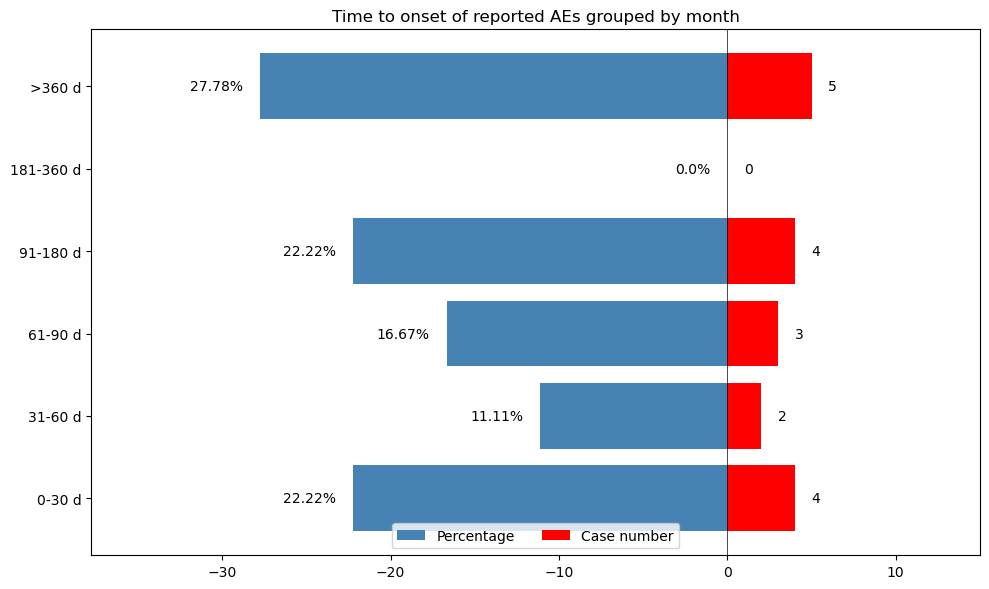

In [62]:
# Define onset bins and labels
bins = [0, 30, 60, 90, 180, 360, float('inf')]
labels = ['0-30 d', '31-60 d', '61-90 d', '91-180 d', '181-360 d', '>360 d']

# Bin the time_to_onset values
query_drug_df_merged_ther['onset_bin'] = pd.cut(
    query_drug_df_merged_ther['time_to_onset'],
    bins=bins,
    labels=labels,
    right=True
)

# Count and percentage
counts = query_drug_df_merged_ther['onset_bin'].value_counts().sort_index()
percentages = (counts / counts.sum() * 100).round(2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = range(len(labels))

# Plot percentages to the left (negative values)
ax.barh(y_pos, -percentages, color='steelblue', label='Percentage')

# Plot counts to the right
ax.barh(y_pos, counts, color='red', label='Case number')

# Add text labels
for i, (pct, count) in enumerate(zip(percentages, counts)):
    ax.text(-pct - 1, i, f"{pct}%", va='center', ha='right', color='black')
    ax.text(count + 1, i, str(count), va='center', ha='left', color='black')

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-max(percentages) - 10, max(counts) + 10)
ax.set_xlabel('')

# Title and legend
ax.set_title('Time to onset of reported AEs grouped by month')
ax.legend(loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

